Prophet est idéal pour ce projet car il est spécifiquement conçu pour modéliser des séries temporelles, comme les émissions de carbone issues des tickets de caisse. Sa capacité à capturer les tendances, la saisonnalité hebdomadaire, et à gérer des données irrégulières ou manquantes en fait un choix pertinent. Il permet également de comparer facilement des scénarios, comme la réduction de 10 % des émissions, et d'évaluer leur impact avec précision grâce à ses intervalles d'incertitude bayésiens. De plus, il s'intègre parfaitement aux outils de visualisation comme Plotly, facilitant l'exploration des données et la présentation des résultats de manière claire et interactive. Prophet est donc un modèle robuste pour prédire, analyser et illustrer les données liées à ce projet.

Aperçu des données :
     Ticket_ID        Date  Produit             Catégorie  Quantité (kg)  \
0  TICKET_6466  2024-08-14  Fromage     Produits laitiers           1.07   
1  TICKET_6466  2024-08-14  Fromage     Produits laitiers           1.40   
2  TICKET_6466  2024-08-14     Porc               Viandes           2.52   
3  TICKET_6466  2024-08-14  Bananes                Fruits           2.19   
4  TICKET_6466  2024-08-14     Café  Produits transformés           2.82   

   Prix au kg (€)  Prix total (€)  CO2_e_per_kg  
0            2.71            2.90          20.0  
1            3.13            4.38          20.0  
2           10.22           25.75           7.0  
3           19.56           42.84           0.8  
4            6.77           19.09          16.0  
Types de colonnes :
Ticket_ID          object
Date               object
Produit            object
Catégorie          object
Quantité (kg)     float64
Prix au kg (€)    float64
Prix total (€)    float64
CO2_e_per_kg      fl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


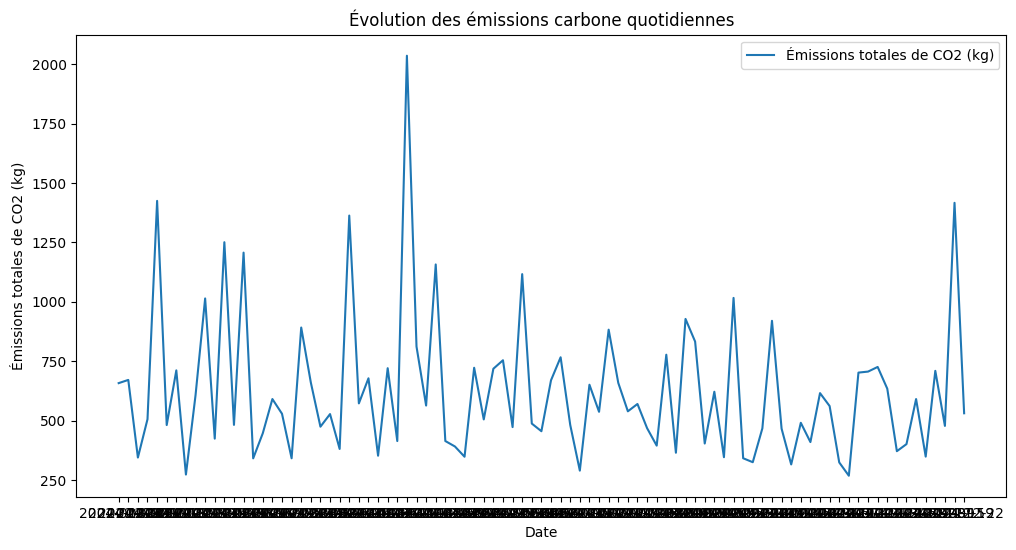

15:33:02 - cmdstanpy - INFO - Chain [1] start processing
15:33:02 - cmdstanpy - INFO - Chain [1] done processing


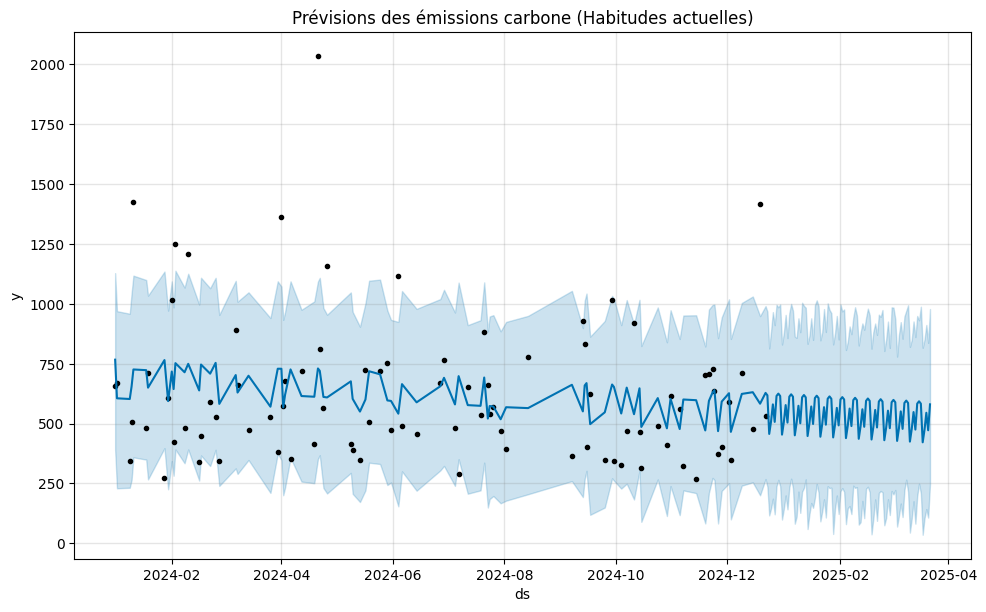

15:33:02 - cmdstanpy - INFO - Chain [1] start processing
15:33:02 - cmdstanpy - INFO - Chain [1] done processing


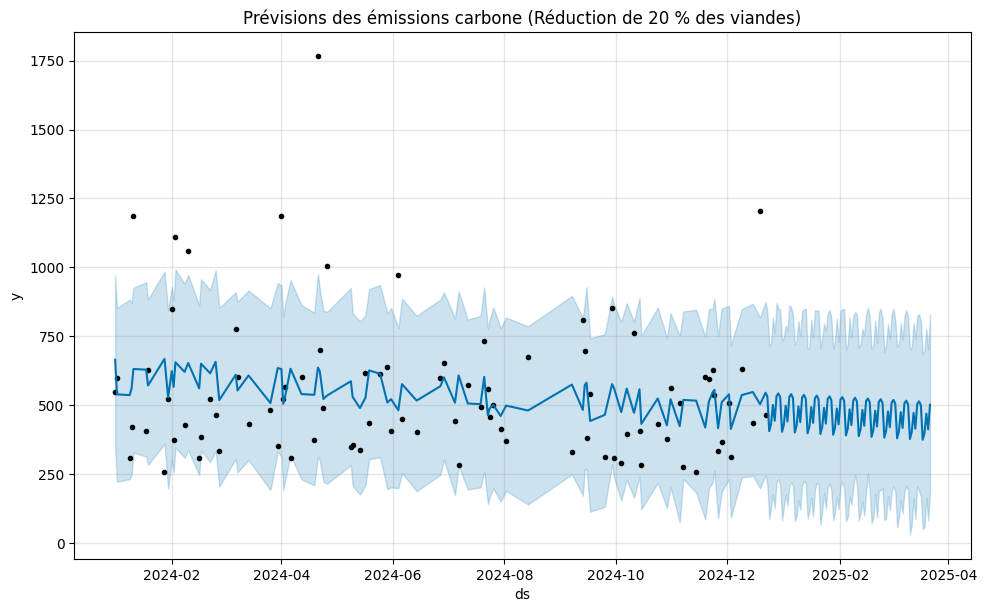

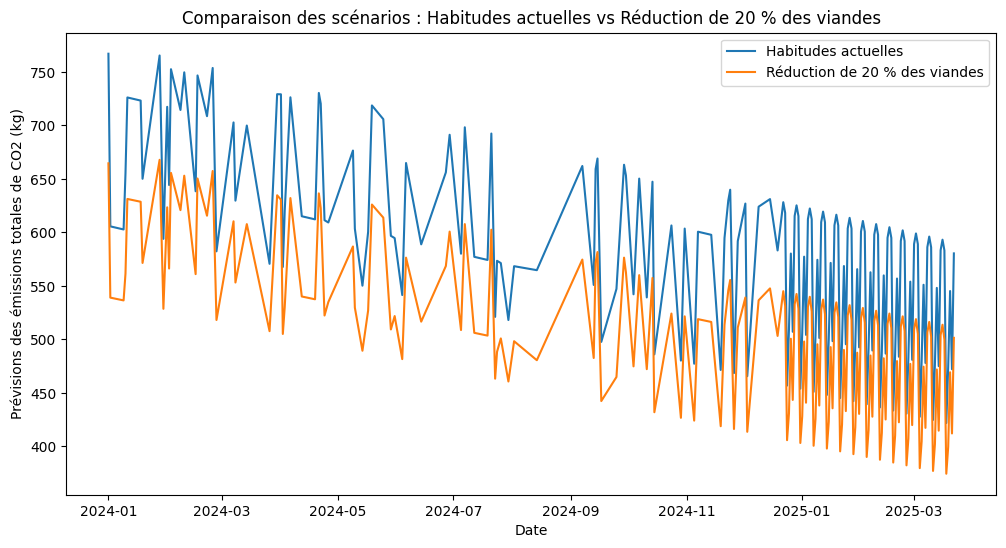

Les prédictions ont été enregistrées dans les fichiers : 'predictions_habitudes_actuelles.csv' et 'predictions_reduction_viandes.csv'.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Chargement des données
file_path = "tickets_caisse_dated_30_articles.csv"  # Chemin vers ton fichier

data = pd.read_csv(file_path)

# Exploration et visualisation des données
print("Aperçu des données :")
print(data.head())

# Vérification des types de données
print("Types de colonnes :")
print(data.dtypes)

# Agrégation des données pour calculer l'empreinte carbone totale par date
data['Total_CO2'] = data['Quantité (kg)'] * data['CO2_e_per_kg']
daily_emissions = data.groupby('Date')['Total_CO2'].sum().reset_index()
daily_emissions.columns = ['ds', 'y']  # Renommer les colonnes pour Prophet

# Visualisation des émissions carbone par jour
plt.figure(figsize=(12, 6))
plt.plot(daily_emissions['ds'], daily_emissions['y'], label='Émissions totales de CO2 (kg)')
plt.xlabel('Date')
plt.ylabel('Émissions totales de CO2 (kg)')
plt.title('Évolution des émissions carbone quotidiennes')
plt.legend()
plt.show()

# Création et entraînement du modèle Prophet
model = Prophet()
model.fit(daily_emissions)

# Génération des prédictions sur une période future
future = model.make_future_dataframe(periods=90)  # Prédire les 90 prochains jours
forecast = model.predict(future)

# Visualisation des prévisions
fig = model.plot(forecast)
plt.title('Prévisions des émissions carbone (Habitudes actuelles)')
plt.show()

# Scénario 1 : Réduction de 20 % des achats de viande
reduced_emissions = daily_emissions.copy()
meat_products = ['Bœuf', 'Porc', 'Poulet', 'Agneau']  # Catégories de viande à réduire

# Réduction de 20 % pour les produits carnés
data['Reduction_CO2'] = data.apply(
    lambda row: row['Total_CO2'] * 0.8 if row['Produit'] in meat_products else row['Total_CO2'], axis=1
)
reduced_emissions = data.groupby('Date')['Reduction_CO2'].sum().reset_index()
reduced_emissions.columns = ['ds', 'y']

# Création et entraînement du modèle pour le scénario réduit
model_reduced = Prophet()
model_reduced.fit(reduced_emissions)

# Génération des prédictions pour le scénario réduit
future_reduced = model_reduced.make_future_dataframe(periods=90)
forecast_reduced = model_reduced.predict(future_reduced)

# Visualisation des prévisions pour le scénario réduit
fig_reduced = model_reduced.plot(forecast_reduced)
plt.title('Prévisions des émissions carbone (Réduction de 20 % des viandes)')
plt.show()

# Comparaison des deux scénarios
forecast['Scenario'] = 'Habitudes actuelles'
forecast_reduced['Scenario'] = 'Réduction de 20 % des viandes'

comparison = pd.concat([
    forecast[['ds', 'yhat', 'Scenario']],
    forecast_reduced[['ds', 'yhat', 'Scenario']]
])

# Visualisation comparative
plt.figure(figsize=(12, 6))
for scenario in comparison['Scenario'].unique():
    subset = comparison[comparison['Scenario'] == scenario]
    plt.plot(subset['ds'], subset['yhat'], label=scenario)

plt.xlabel('Date')
plt.ylabel('Prévisions des émissions totales de CO2 (kg)')
plt.title('Comparaison des scénarios : Habitudes actuelles vs Réduction de 20 % des viandes')
plt.legend()
plt.show()

# Enregistrement des prédictions dans un fichier
forecast.to_csv("predictions_habitudes_actuelles.csv", index=False)
forecast_reduced.to_csv("predictions_reduction_viandes.csv", index=False)
print("Les prédictions ont été enregistrées dans les fichiers : 'predictions_habitudes_actuelles.csv' et 'predictions_reduction_viandes.csv'.")
